# Roll No : 2022201060 CV-ASSIGNMENT 4 PART1

## Q1: Segmentation
### 1. Preparation. We will use an existing illustrative code for segmentation using a Unet in Pytorch. Please make a copy of the following notebook as a google colab project and ensure you are able to run it: https://www.kaggle.com/code/dhvananrangrej/image-segmentation-with-unet-pytorch/notebook.

The first cell should contain the necessary code to download the segmentation dataset (a subset of Cityscapes). Carefully study the code, especially focusing on the data and model.
Do not change the model definition, dataset class, or evaluation metric (currently being computed over 10 images or 1 batch of the validation set). You may need to fix one bug iter(data_loader).next(), but this does not influence the other parts.
Hint: You may train the model for 1 epoch as it takes quite some time to complete all 10 epochs.


### 1. Setup Libraries & device

In [90]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [91]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


### 2. Configure data locations

In [92]:
data_dir = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


### 3. Analyze data

/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


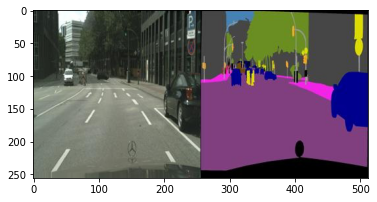

In [93]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

### 4. Extract Image and Labels

The input images contain both the road scene and the corresponding label in the same image. Thus, we are splitting it and presenting it as two separate entities.

In [94]:
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label

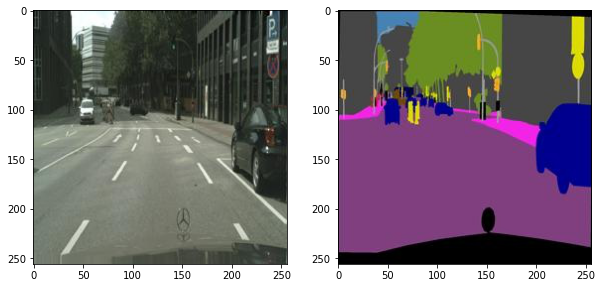

In [95]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

### 5. Define Labels

We use K-means clustering to segregate the objects of different colors and assign them class labels.   

In [96]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
print(color_array.shape)

(1000, 3)


In [97]:
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=10)

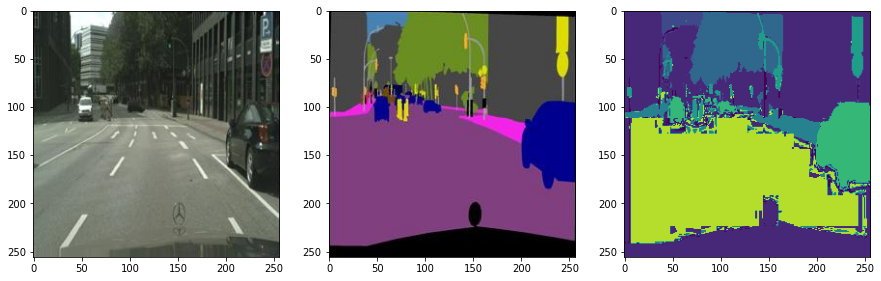

In [98]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1,3)).reshape(256,256)
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [99]:
label_class

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

### 6. Define Dataset

In [100]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self):
    return len(self.image_fns)
  
  def __getitem__(self, index):
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp).convert("RGB")
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1,3)).reshape(256,256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label
  
  def transform(self, image):
    transform_ops = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [101]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [102]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


### 7. Define Model 


In [103]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [104]:
model = UNet(num_classes=num_classes)

In [105]:
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [106]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


### 8. Train the model

In [107]:
batch_size = 16

epochs = 1
lr = 0.01

In [108]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

In [109]:
model = UNet(num_classes = num_classes).to(device)

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [111]:
step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader, total=len(data_loader), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

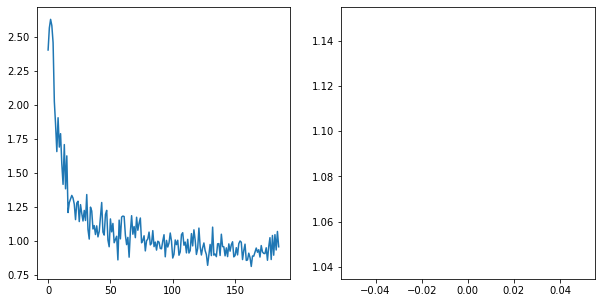

In [112]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [113]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

### 9. Check model predictions

In [114]:
model_path = "/kaggle/working/U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [115]:
test_batch_size = 10
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [116]:
X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [117]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

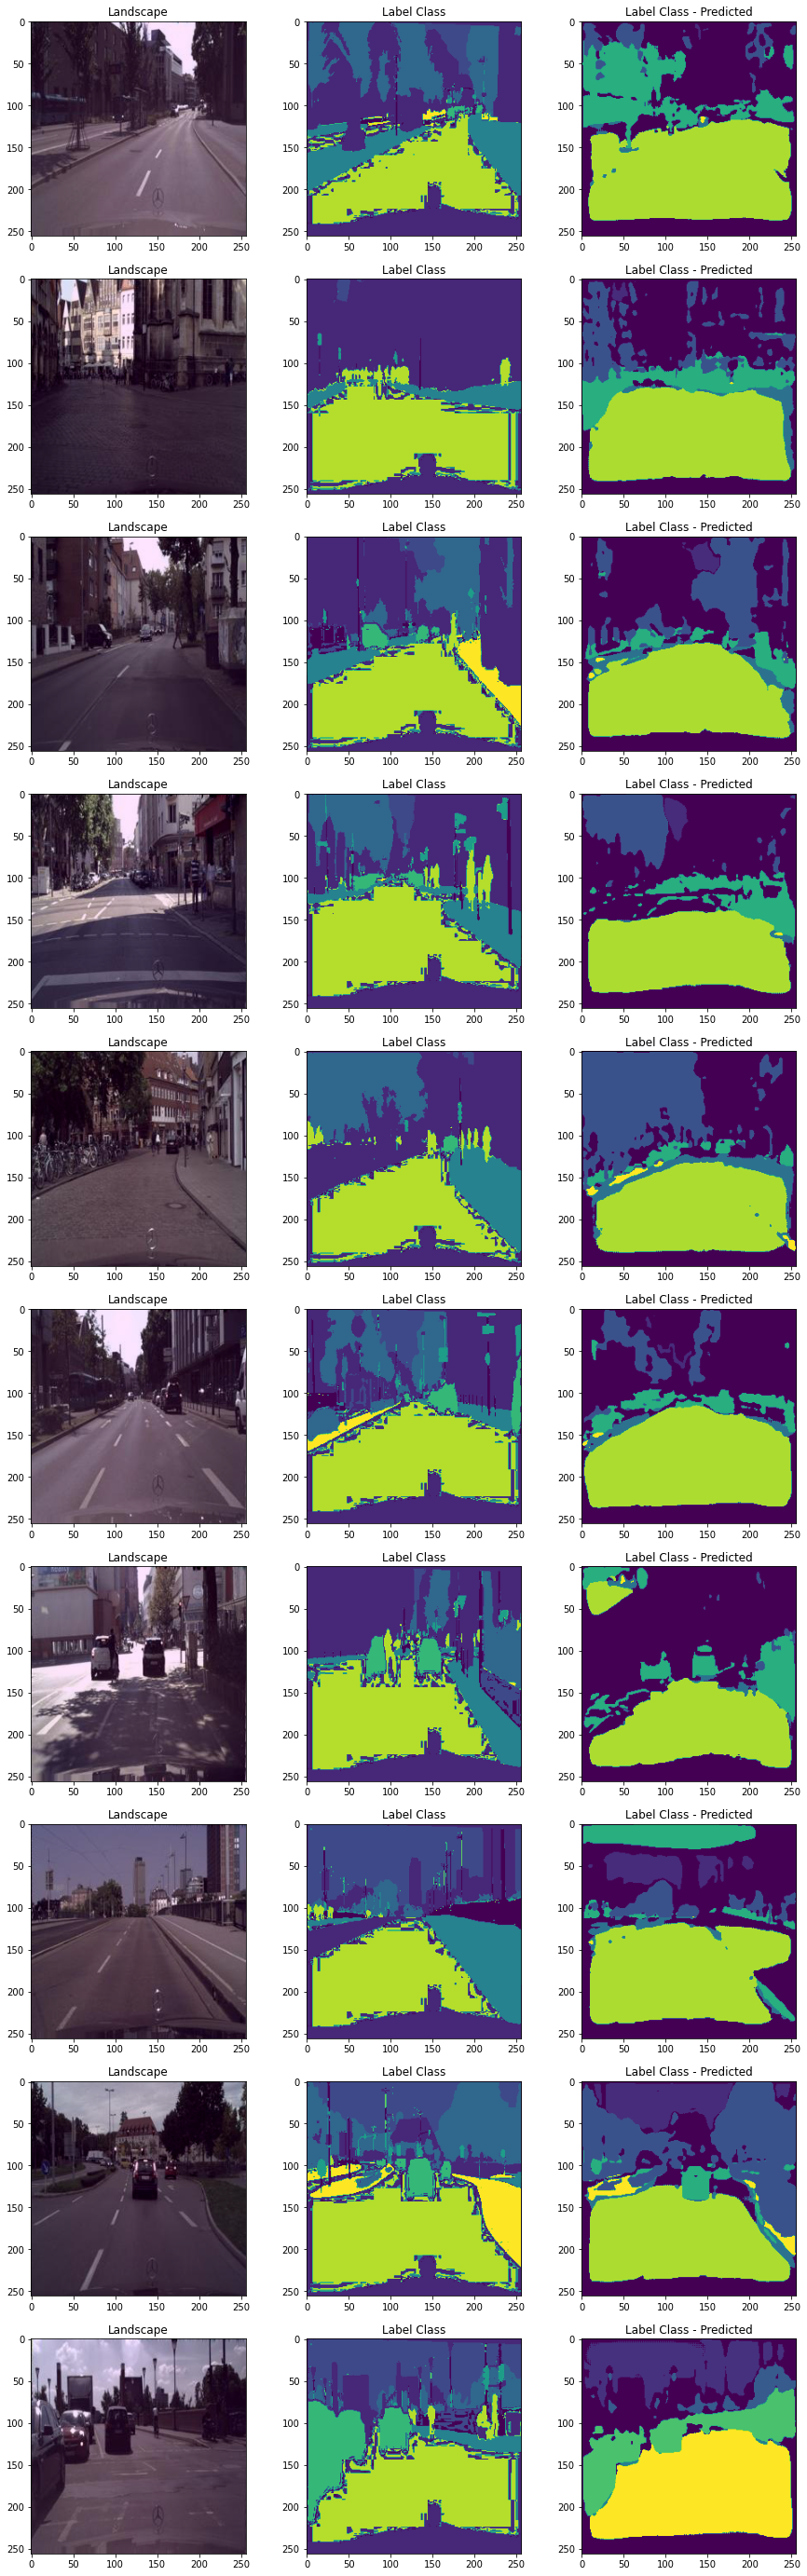

In [118]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [119]:
print(sum(iou_scores) / len(iou_scores))

0.9736221313476563


## 2. Importance of skip connections. The above model is a standard Unet architecture. The key novelty in the Unet are the skip connections between the encoder and decoder. But how important are they?
In this experiment, modify the model to disconnect the skip connections. As compared to the original model, does the new model perform well? Report the results, both qualitatively and quantitatively (IoU over the same 10 images as before).
Hint 1: When removing the skip connections, you will need to halve the number of input channels too.
Hint 2: For a fair comparison to the above model, please train the new model without skip connections for the same number of epochs (1 if you followed the above point!).

In [120]:
class UNet_wSkip(nn.Module):
 
    def __init__(self, num_classes):
        super(UNet_wSkip, self).__init__()
        self.num_classes = num_classes
        self.in_channels = 3
        self.contracting_11 = self.conv_block(in_channels=self.in_channels, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.middle = self.conv_block(in_channels=512, out_channels=1024)

        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=512, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=256, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=128, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=64, out_channels=64)

        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    def conv_block(self, in_channels, out_channels):
        c_block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return c_block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(expansive_11_out) # [-1, 512, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 512, 64, 64]
        expansive_22_out = self.expansive_22(expansive_21_out) # [-1, 256, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(expansive_31_out) # [-1, 128, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(expansive_41_out) # [-1, 64, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out


In [121]:
model_wskip = UNet_wSkip(num_classes=num_classes)

In [122]:
data_loader_wskip = DataLoader(dataset, batch_size = 16)
print(len(dataset), len(data_loader_wskip))

X, Y = next(iter(data_loader_wskip))
print(X.shape, Y.shape)

500 32
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [123]:
Y_pred = model_wskip(X)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


In [124]:
batch_size = 16
epochs = 1
lr = 0.01

In [125]:
dataset_wskip = CityscapeDataset(train_dir, label_model)
data_loader_wskip = DataLoader(dataset, batch_size = batch_size)

In [126]:
model_wSkip = UNet_wSkip(num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_wSkip.parameters(), lr = lr)

In [127]:
step_losses_wskip = []
epoch_losses_wskip = []

for epoch in tqdm(range(epochs)):
  epoch_loss = 0
  for X,Y in tqdm(data_loader_wskip, total=len(data_loader_wskip), leave = False):
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model_wSkip(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses_wskip.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader_wskip))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

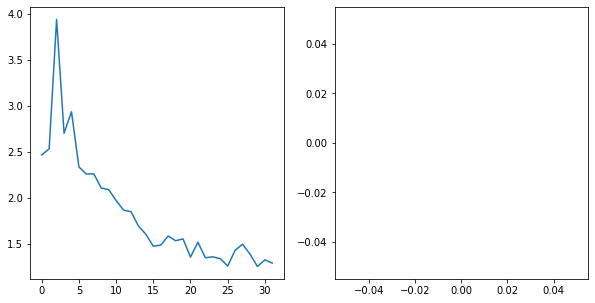

In [128]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(step_losses_wskip)
axes[1].plot(epoch_losses_wskip)

In [129]:
model_name_wskip = "U-Net_wskip.pth"
torch.save(model_wSkip.state_dict(), model_name_wskip)

In [130]:
model_path_wskip = "/kaggle/working/U-Net_wskip.pth"
model_wskip = UNet_wSkip(num_classes=num_classes).to(device)
model_wskip.load_state_dict(torch.load(model_path_wskip))

<All keys matched successfully>

In [131]:
test_batch_size = 10
dataset_wskip = CityscapeDataset(val_dir, label_model)
data_loader_wskip = DataLoader(dataset_wskip, batch_size=test_batch_size)

In [132]:
X,Y = next(iter(data_loader_wskip))
X,Y = X.to(device), Y.to(device)
Y_pred = model_wskip(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([10, 10, 256, 256])
torch.Size([10, 256, 256])


In [133]:
inverse_transform_wskip = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

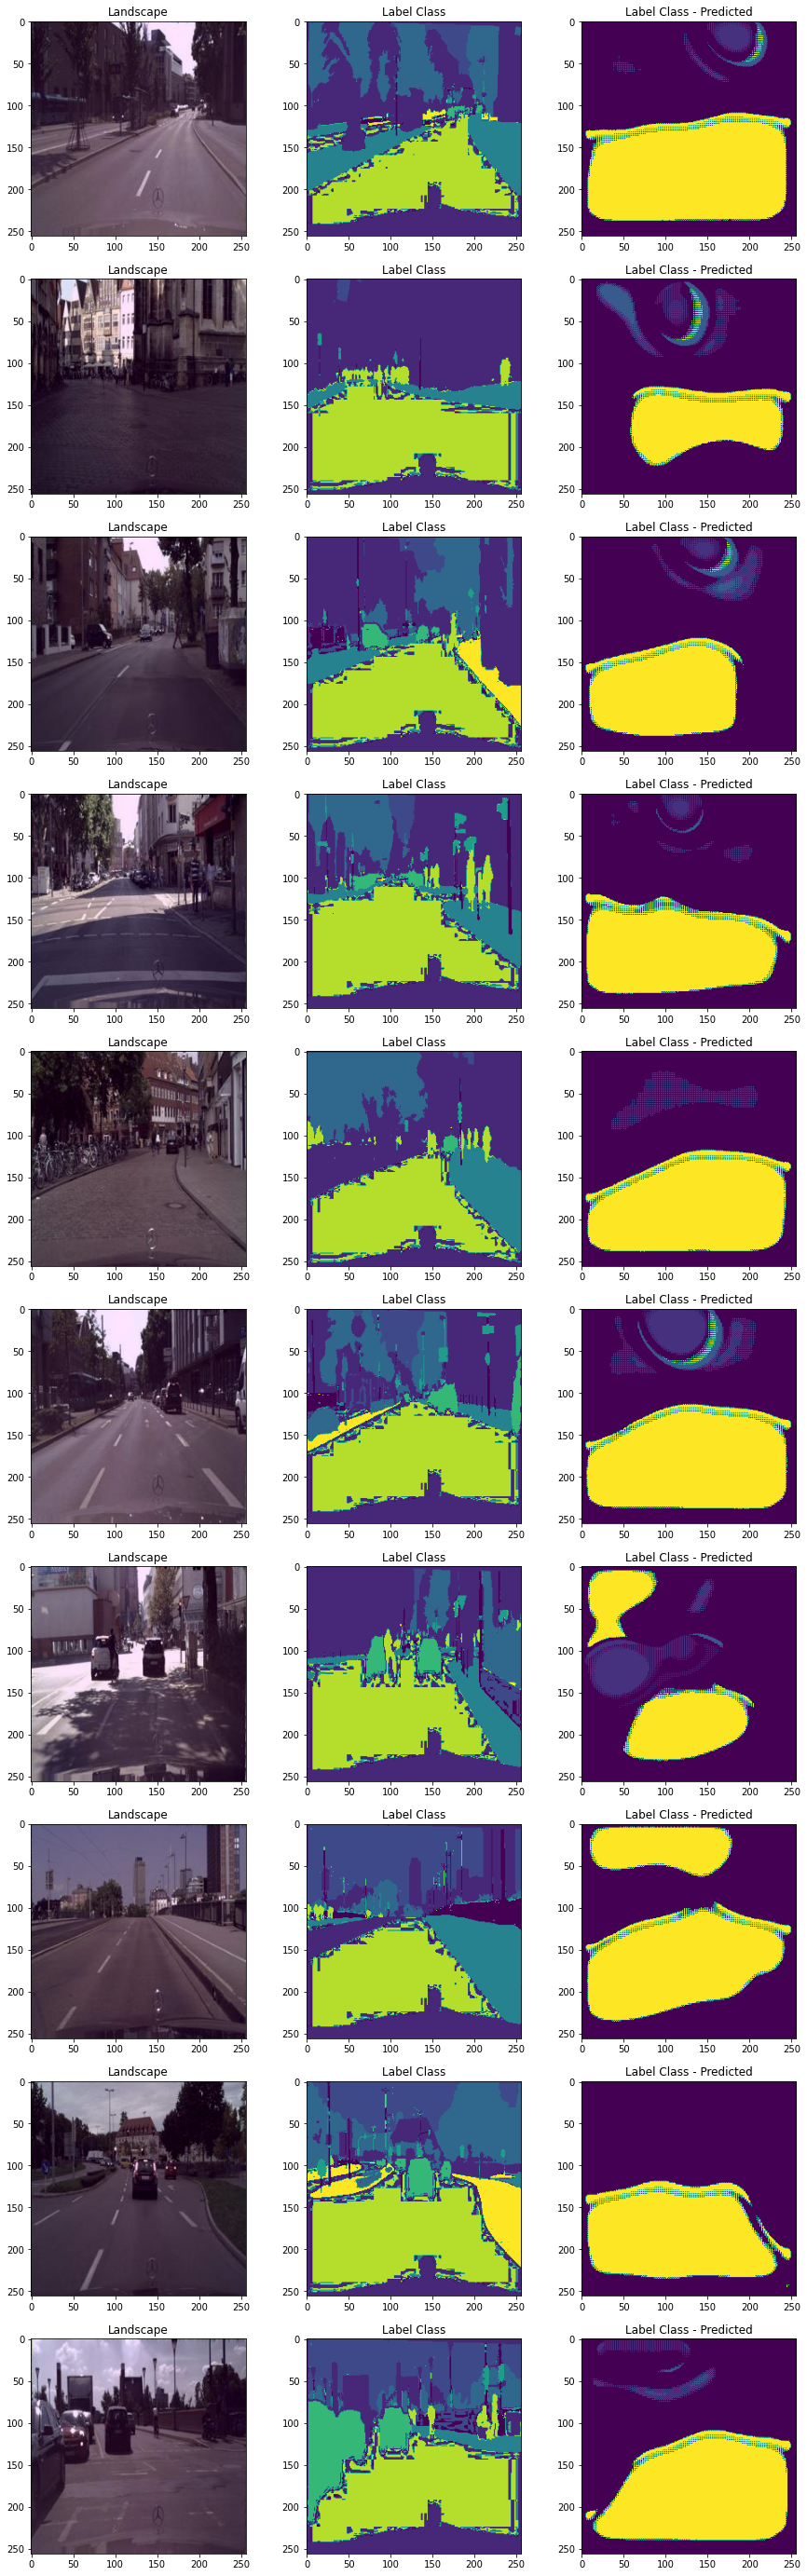

In [134]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores_wskip = []

for i in range(test_batch_size):
    
    landscape = inverse_transform_wskip(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score_wskip = np.sum(intersection) / np.sum(union)
    iou_scores_wskip.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [135]:
print(sum(iou_scores_wskip) / len(iou_scores_wskip))

0.9663238525390625


## 3. `Metric` The metric implemented in the notebook calculates IoU directly (logical_and and logical_or) and does not seem correct.
- First, explain what is the issue with the metric in the current form.
- Next, re-write the metric function to instead compute an IoU for each class. Report the mean over all classes as the score for each image, and the mean over all images as the score for the validation set (or 10 images therein).
- Is the mIoU score different between the model with and without skip connections? Explain why.


### 1.3.1 First, explain what is the issue with the metric in the current form.

### Answer : 
The issue with the current metric is its simplistic calculation of IoU using logical AND and OR operations without considering individual classes. This approach lacks class differentiation, making it unable to handle class imbalance and provide interpretable results. To address these limitations, a more comprehensive metric is needed, one that calculates IoU for each class separately, considers class weights, and provides insights into segmentation performance across different classes.

### 1.3.2 Next, re-write the metric function to instead compute an IoU for each class. Report the mean over all classes as the score for each image, and the mean over all images as the score for the validation set (or 10 images therein).

In [136]:


def calculate_iou_per_class(Y_true, Y_pred, num_classes):
    iou_per_class = []
    for class_idx in range(num_classes):
        intersection = np.logical_and(Y_true == class_idx, Y_pred == class_idx)
        union = np.logical_or(Y_true == class_idx, Y_pred == class_idx)
        if union.sum() == 0:
            iou_per_class.append(0)
        else:
            iou_per_class.append(intersection.sum() / union.sum())
    return iou_per_class

def compute_mean_iou(Y_true, Y_pred, num_classes):
    iou_per_class = calculate_iou_per_class(Y_true, Y_pred, num_classes)
    return np.mean(iou_per_class)

def validate_model(model, data_loader, num_classes, device):
    iou_scores = []
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        predicted_labels = torch.argmax(predictions, dim=1)
        for i in range(predicted_labels.shape[0]):
            iou_score = compute_mean_iou(labels[i].cpu().detach().numpy(), 
                                         predicted_labels[i].cpu().detach().numpy(), 
                                         num_classes)
            iou_scores.append(iou_score)
    return np.mean(iou_scores)

def calculate_iou_for_image(model, device, image, label, num_classes):
    image, label = image.to(device), label.to(device)
    predictions = model(image)
    predicted_label = torch.argmax(predictions, dim=1)
    iou_score = compute_mean_iou(label[0].cpu().detach().numpy(), 
                                 predicted_label[0].cpu().detach().numpy(), 
                                 num_classes)
    return iou_score


In [137]:
# Calculate IoU for a single image using the model with skip connections
iou_per_image_skip = calculate_iou_for_image(model_, device, X, Y, num_classes)
print("Mean IoU for Per Image (Skip Connections): ", iou_per_image_skip)

# Calculate IoU for a single image using the model without skip connections
iou_per_image_no_skip = calculate_iou_for_image(model_wskip, device, X, Y, num_classes)
print("Mean IoU for Per Image (No Skip Connections): ", iou_per_image_no_skip)

# Validate the model with skip connections and calculate mean IoU for all images
mean_iou_skip = validate_model(model_, data_loader, num_classes, device)
print("Mean IoU Score for all images (Skip Connection):", mean_iou_skip)

# Validate the model without skip connections and calculate mean IoU for all images
mean_iou_no_skip = validate_model(model_wskip, data_loader, num_classes, device)
print("Mean IoU Score for all images (No Skip Connection):", mean_iou_no_skip)


Mean IoU for Per Image (Skip Connections):  0.12940936339813486
Mean IoU for Per Image (No Skip Connections):  0.15986931918314434
Mean IoU Score for all images (Skip Connection): 0.24734043252965762
Mean IoU Score for all images (No Skip Connection): 0.12317609299948754


### 1.3.3 Is the mIoU score different between the model with and without skip connections? Explain why.

### Answer : 
 
Yes, the mIoU score is different between the model with and without skip connections. This difference arises due to the architectural differences between the two models and how they handle information flow through the network.

Skip connections, also known as residual connections, allow information from early layers to bypass several layers and directly reach deeper layers of the network. This helps in mitigating the vanishing gradient problem and enables better gradient flow during training. 

In the context of semantic segmentation, skip connections can improve the model's ability to capture fine-grained details and spatial information by retaining high-resolution feature maps from earlier layers. This is particularly beneficial when dealing with objects of varying sizes and complex spatial structures.

Therefore, a model with skip connections may have a higher mIoU score compared to a model without skip connections because it can better preserve spatial details and capture fine-grained information, leading to more accurate segmentation results.